In [9]:
import numpy as np
import pandas as pd
import sqlite3
from sqlite3 import Error
import matplotlib.pyplot as plt
import seaborn as sns

import imblearn

from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report

import pickle
import xgboost as xgb

In [2]:
### download the db from link in readme
db_path = "../../dbs/delays_new.db"

In [3]:
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        connection.text_factory = str
    except Error as e:
        print("Error occurred: " + str(e))
    return connection


def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        if query == "":
            return "Query Blank"
        else:
            df = pd.read_sql_query(query, connection)
            return df
    except Error as e:
        return "Error occurred: " + str(e)

In [4]:
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [5]:
def preprocess_inputs(df, use_departure_delay):
    df = df.copy()
    
    if (not use_departure_delay):
        df = df.drop('DepDelay', axis=1)
    
    y = (df.ArrDelay>15).astype(int)
    
    df = df.drop('ArrDelay', axis=1)
    
    # One-hot encode nominal feature columns
    X = onehot_encode(
        df,
        column_dict={
            'IATA_CODE_Reporting_Airline': 'AL',
            'OriginAirportID': 'OA',
            'DestAirportID': 'DA',
            'Month': 'M',
            'DayofMonth': 'DM',
            'DayOfWeek': 'DW',
            'DepHour' : 'DH',
        }
    )
    
    encoding_file = 'encoding.sav'
    pickle.dump()
    
    smote = SMOTE()
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    
    # Todo: only apply this to columns that need it    
    # Scale X with a standard scaler
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
   
    return X_train, X_test, y_train, y_test

In [6]:
def evaluate_model(model, X_test, y_test):
    
    model_acc = model.score(X_test, y_test)
    print("Test Accuracy: {:.2f}%".format(model_acc * 100))
    
    y_true = np.array(y_test)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_true, y_pred)
    clr = classification_report(y_true, y_pred, target_names=["Not Delayed", "Delayed"])
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.yticks(np.arange(2) + 0.5, ["Not Delayed", "Delayed"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

In [7]:
sample_query = \
    """
        select 
         Month,
         DayofMonth,
         DayOfWeek,
         SUBSTR(CRSDepTime, 1, LENGTH(CRSDepTime)-2) as DepHour,
         IATA_CODE_Reporting_Airline,
         OriginAirportID,
         DestAirportID,
         AirTime,
         DepDelay,
         ArrDelay
        from 
          delay
         where Cancelled = 0  
         and AirTime > 0 
        order by RANDOM() LIMIT 100000
    """

connection = create_connection(db_path)
data =  execute_query(connection, sample_query)

In [8]:
data

,Month,DayofMonth,DayOfWeek,DepHour,IATA_CODE_Reporting_Airline,OriginAirportID,DestAirportID,AirTime,DepDelay,ArrDelay
0,2,17,1,15,EV,12266,13871,111,32,34
1,2,10,7,13,WN,14100,13204,124,5,-7
2,4,11,6,10,DL,11292,10397,140,127,108
3,8,26,2,12,OO,11433,14696,30,16,4
4,7,31,2,16,EV,11618,11278,41,-4,-27
...,...,...,...,...,...,...,...,...,...,...
99995,2,12,5,14,F9,13204,15016,141,-6,-9
99996,10,21,1,13,DL,12478,10994,93,14,20
99997,9,25,3,20,WN,10800,14893,54,-2,4
99998,6,7,1,18,UA,13930,10792,66,49,42


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Test Accuracy: 80.94%


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


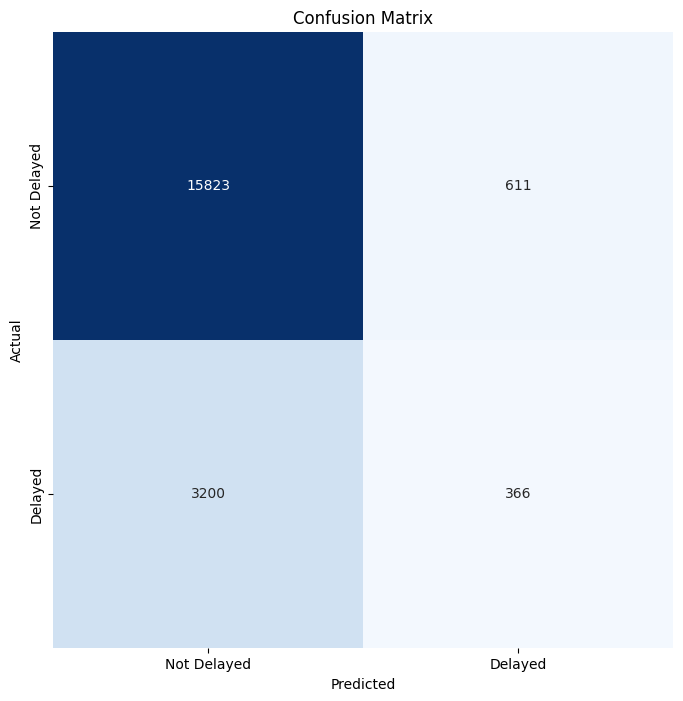

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.83      0.96      0.89     16434
     Delayed       0.37      0.10      0.16      3566

    accuracy                           0.81     20000
   macro avg       0.60      0.53      0.53     20000
weighted avg       0.75      0.81      0.76     20000



In [9]:
X_train, X_test, y_train, y_test = preprocess_inputs(data, use_departure_delay=False)
clf_rf = RandomForestClassifier(n_estimators = 100, verbose=1, n_jobs=-1) 
clf_rf.fit(X_train, y_train)
evaluate_model(clf_rf, X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


Test Accuracy: 93.32%


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


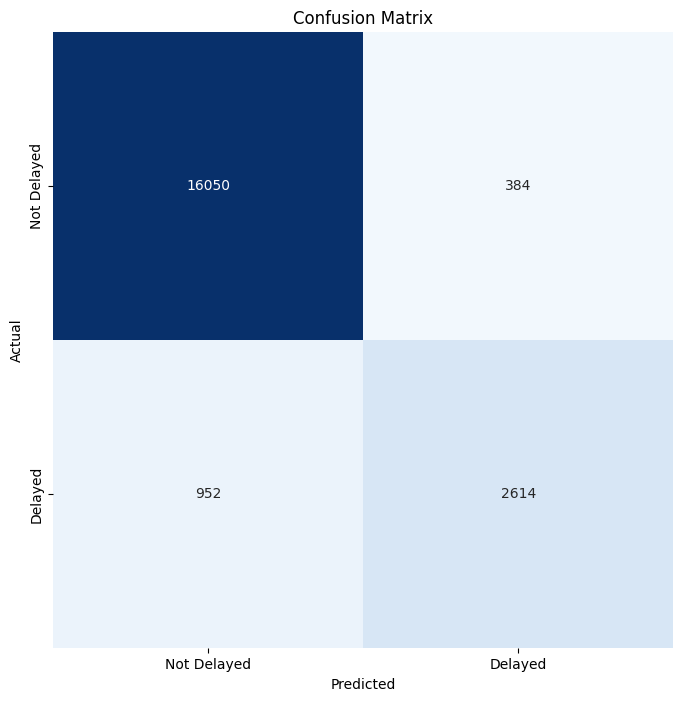

Classification Report:
----------------------
               precision    recall  f1-score   support

 Not Delayed       0.94      0.98      0.96     16434
     Delayed       0.87      0.73      0.80      3566

    accuracy                           0.93     20000
   macro avg       0.91      0.85      0.88     20000
weighted avg       0.93      0.93      0.93     20000



In [10]:
X_train, X_test, y_train, y_test = preprocess_inputs(data, use_departure_delay=True)
clf_rf = RandomForestClassifier(n_estimators = 100, verbose=1, n_jobs=-1) 
clf_rf.fit(X_train, y_train)
evaluate_model(clf_rf, X_test, y_test)

In [11]:
# xgb_cl = xgb.XGBClassifier()

# # Fit
# xgb_cl.fit(X_train, y_train)

# evaluate_model(xgb_cl, X_test, y_test)